In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utility import type_to_rang, make_BMI

plt.rcParams['figure.figsize'] = [14, 9]

In [2]:
data = pd.read_csv('../data/train.csv', index_col='id')

data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

## Признаки:

- FAVC - частое употребление высококалорийной пищи
- FCVC - частота употребления овощей
- NCP - количество основных приемов пищи
- CAEC - потребление пищи между приемами пищи
- CH2O - ежедневное потребление воды
- SCC - мониторинг потребления калорий
- FAF - частота физической активности
- TUE - время использования технологических устройств
- CALC - потребление алкоголя
- MTRANS - используемый транспорт

In [4]:
numerical = data.dtypes[data.dtypes == 'float64'].index
categorical = data.dtypes[data.dtypes == 'object'].index

## Обзор вещественных признаков:

In [5]:
data[numerical].describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


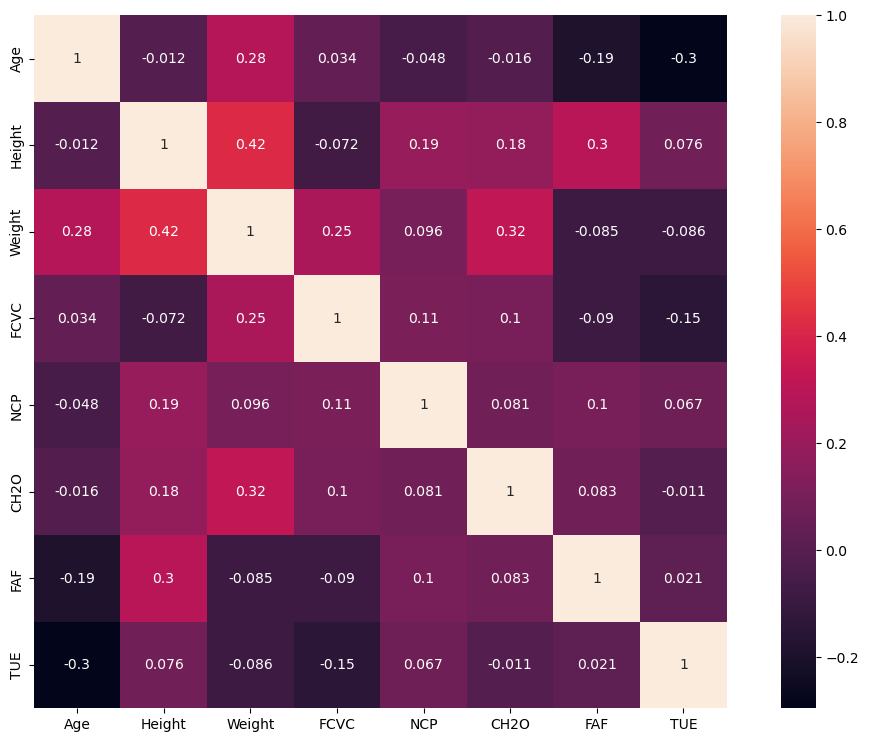

In [6]:
sns.heatmap(data[numerical].corr(), square=True, annot=True)
plt.show()

Кажется, что сильных корреляций нет. Больше всего между колонками Height и Weight, чья взаимосвязь логична. Вероятно имеет смысл заменить их на Индекс Массы Тела (вес / рост ** 2).

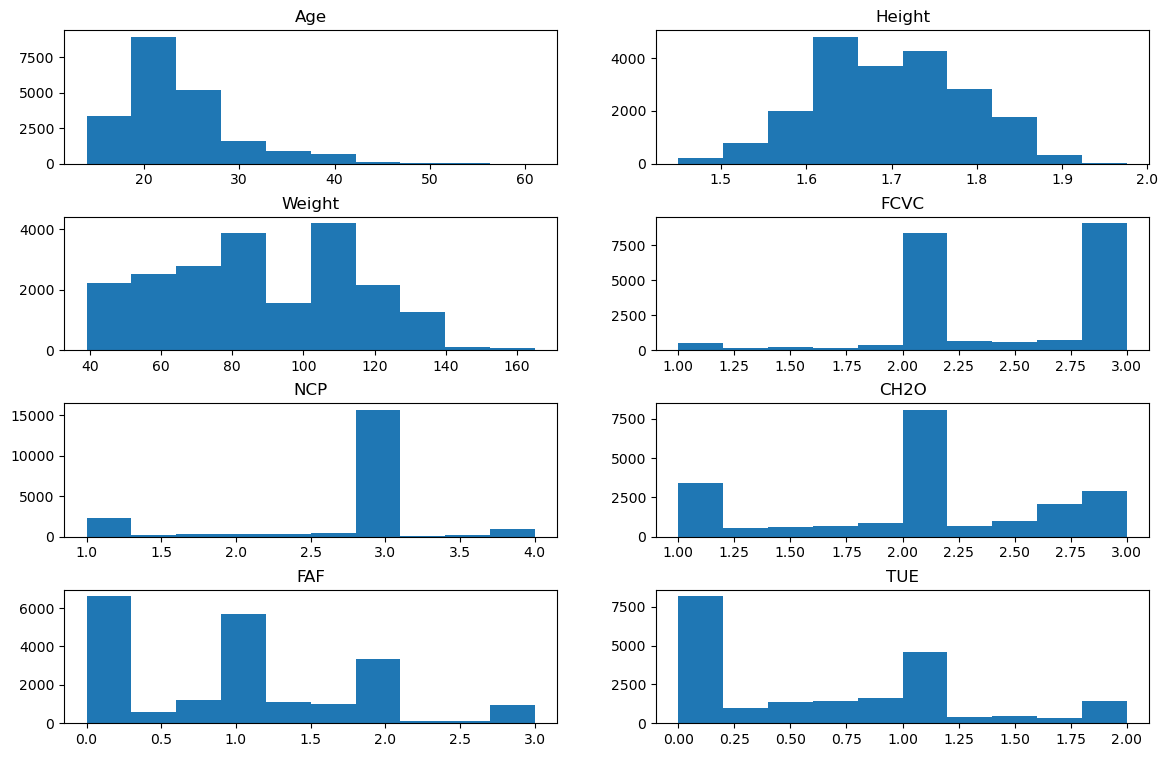

In [7]:
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.hist(data[numerical[i]])
    plt.title(numerical[i])

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()    

## Оценка распределения

Возраст:
Скорее логнормальное, вероятно, исследование проводилось "с n лет"

Рост:
Более-менее похоже на нормальное

Вес:
Странное провисание в середине и левый хвост. Стоит иметь в виду, что возможно есть какие-то аномальные значения

FCVC, NCP, CH2O, FAF, TUE:
Выглядят так, потому что построены на основе анкетирования, где являлись катгориальными переменными. Сначала я решил, что это галюцинации модели, которая генерировала данные, но в оригинальных данных есть тоже самое. Поэтому приводить их к категориальным значениям не стал.

Теперь посмотрим, как представлены распределения в зависимости от таргетного значения.

In [8]:
data['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

Таргет можно еще рассмотреть как ранговую переменную и далее построить модель регрессии (с округлением), а не классификации. Также, можно попробовать посмотреть корреляции после перевода в ранговое значение.

In [9]:
data['rang'] = data['NObeyesdad'].apply(type_to_rang)

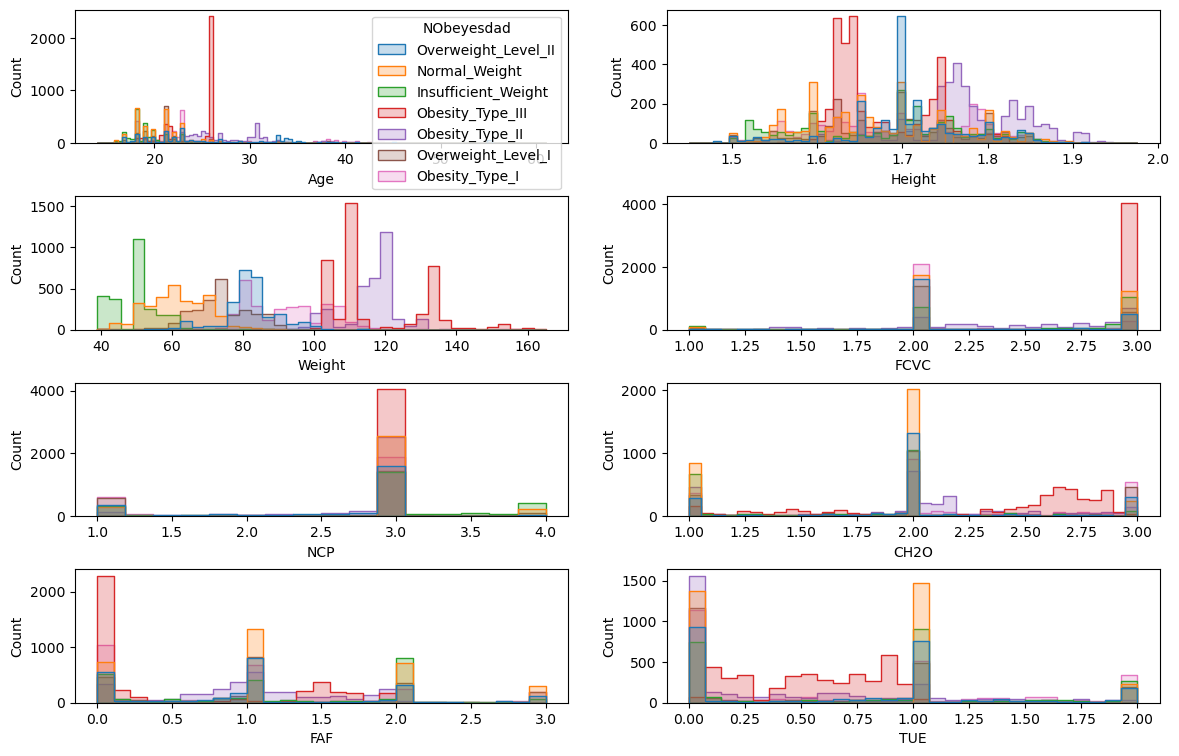

In [10]:
for i in range(8):
    legend = True if i == 0 else False 
    plt.subplot(4, 2, i+1)
    sns.histplot(data=data, x=numerical[i], hue='NObeyesdad', element="step", fill=True, legend=legend)

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()  

Для построения боксплотов использую ранги, чтобы последовательность графиков была более наглядна и соответстовала ранговому значению таргета.

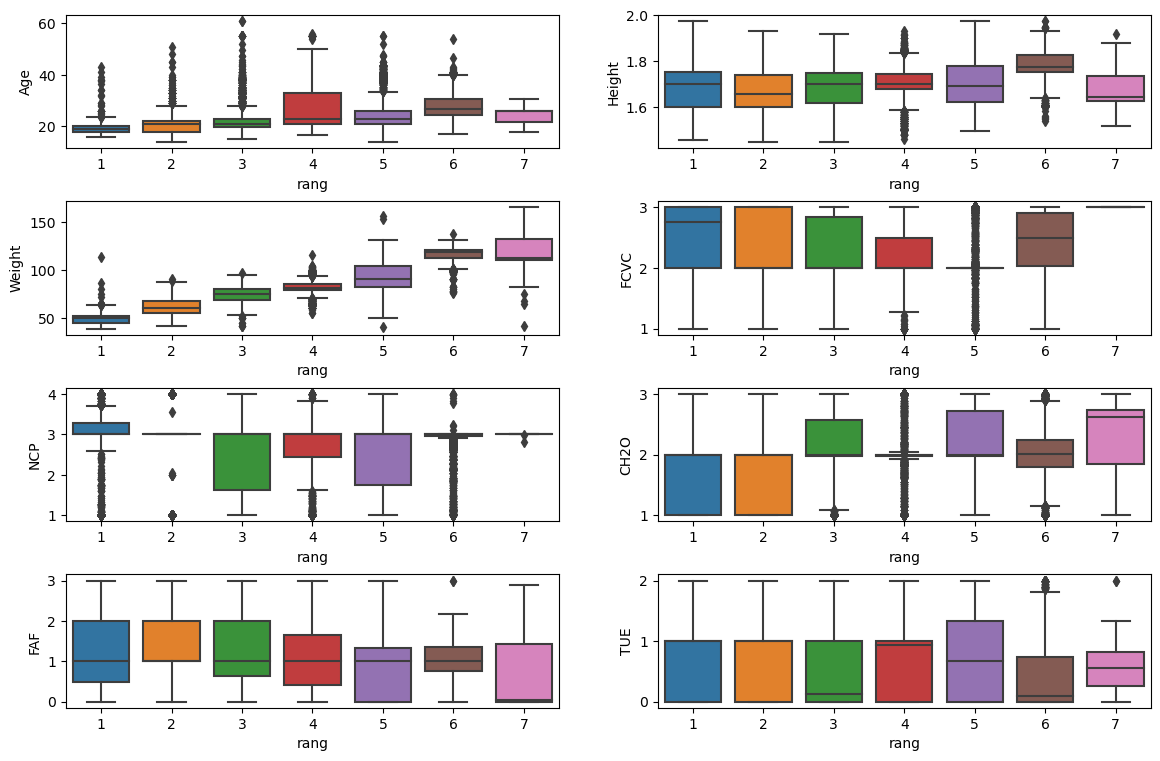

In [11]:
for i in range(8):
    plt.subplot(4, 2, i+1)
    sns.boxplot(data=data, x='rang', y=numerical[i])

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()  

Значение веса, вероятно самый важный признак. Смущают странные выбросы для "недовеса" и ожирения третьей степени.
Ящик для перевеса второй степени на многих признаках содержит выбросы, стоит проверить, насколько сбалансированны классы.

In [12]:
data.rang.value_counts()

7    4046
6    3248
2    3082
5    2910
1    2523
4    2522
3    2427
Name: rang, dtype: int64

Кажется, каждый класс представлен достаточно.
Посмотрим на объекты с весом больше 100 и таргетом "недовес".

In [13]:
data[(data['rang'] == 1) & (data['Weight'] > 100)]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,rang
id,,,,,,,,,,,,,,,,,,
8742,Male,28.421533,1.758382,113.714521,yes,yes,1.064162,3.985442,Sometimes,no,2.022933,no,1.980401,0.775378,Sometimes,Automobile,Insufficient_Weight,1


Вероятно, в данных есть ошибки. Рост немного выше среднего (среднее 1.70), вес существенно выше среднего (среднее 87.89). Нужно подумать, как обойтись с выбросами.
Создадим новый признак: отношение роста к весу и посмотрим корреляцию между рангами и количественными признаками.

In [14]:
data['BMI'] = make_BMI(data)

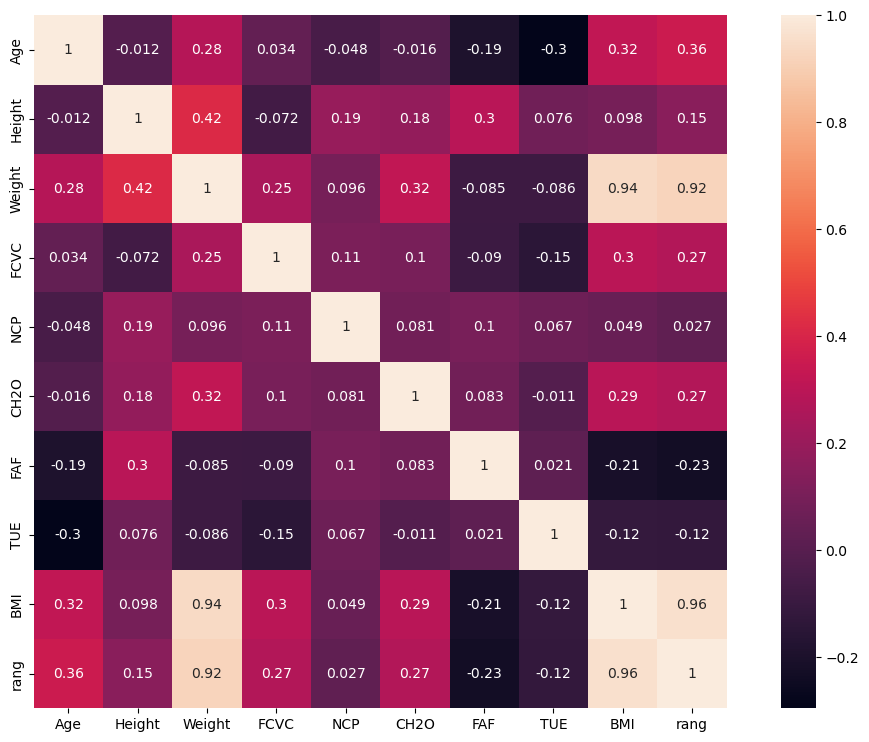

In [15]:
sns.heatmap(data[list(numerical) + ['BMI'] + ['rang']].corr(), square=True, annot=True)
plt.show()

Что довольно интуитивно, корреляция таргета с весом очень сильная. При этом корреляция с BMI ещё сильнее. В качестве варианта базовой модели можно попробовать модель регрессии опирающуюся на BMI. И потом посмотреть варианты ее усложнения.

## Обзор категориальных фичей:

In [16]:
data[categorical].describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


Кроме колонок Gender и таргета, в других категориальных колонках довольно существенный дисбаланс. На этапе тестирования модели стоит рассмотреть вариант отказа от таких колонок как, например, SMOKE  и SCC где почти все данные одной категории.

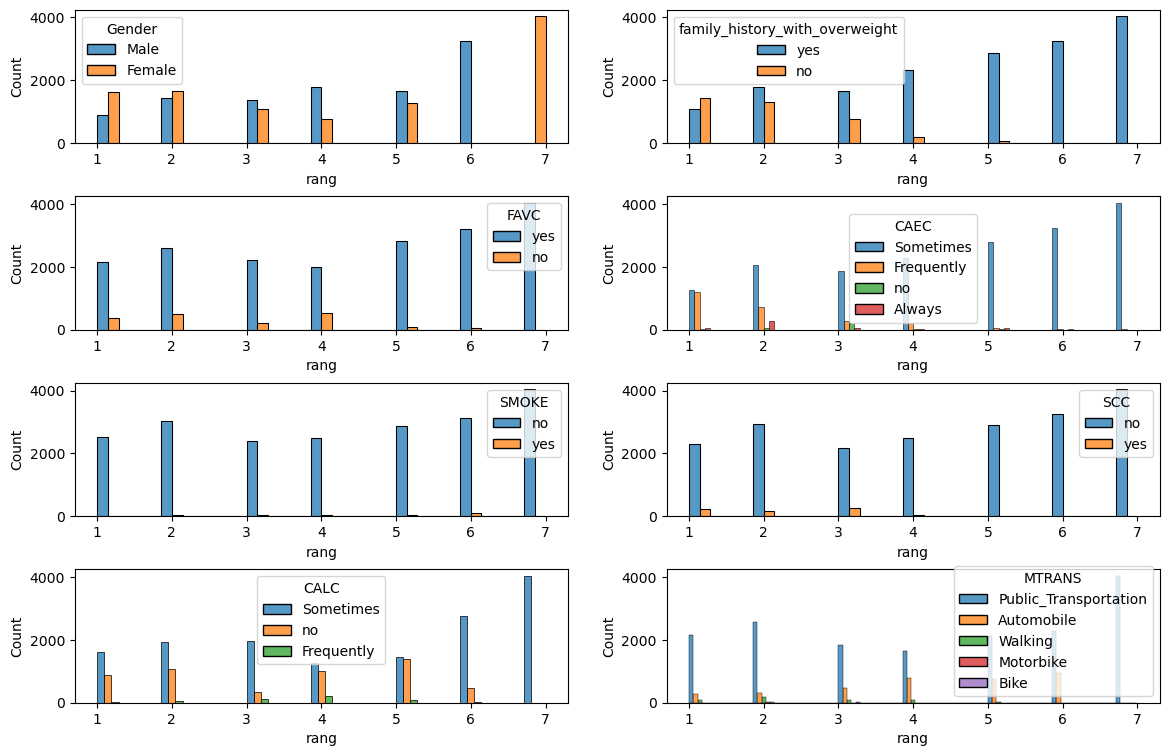

In [17]:
for i in range(8):
    plt.subplot(4, 2, i+1)
    sns.histplot(data=data, x='rang', hue=categorical[i], multiple="dodge")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()  

In [18]:
data[data['rang'] == 7]['Gender'].value_counts()

Female    4041
Male         5
Name: Gender, dtype: int64

In [19]:
data[data['rang'] == 6]['Gender'].value_counts()

Male      3240
Female       8
Name: Gender, dtype: int64

Странные значения по полу, ожирение 2 степени - подавляющее большинство - женщины, третьеё - мужчины. В целом, набиолее полензыми кажутся признаки пола и истории семьи. Возможно, SCC, мониторинг потребления калорий.
Признак курения кажется наиболее бесполезным.

Хотя в данных присутствуют выбросы, попробую сначала построить модель без очистки, так как тестовые данные были также сгенерированы, есть вероятность, что выбросы будут присутствовать и там.
Так как выбросы есть на крайнем значении (1) вероятно регрессионная модель может тянуться в эту сторону. Проверим простую модель без очистки и с очисткой, чтобы сравнить, насколько существенно выбросы зашумляют модель.